<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from math import ceil
from datetime import datetime
from collections import Counter

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = "C:\\Users\\arxei\\Anaconda\\CourseraDeepLearning\\Course6\\UsersIdentification"

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    
    csv_files = glob(path_to_csv_files + "/user????.csv")
    
    with open(site_freq_path, 'rb') as f:
        site_to_id_freq = pickle.load(f)
    
    site_index = 1
    
    df_columns = ["site" + str(i) for i in np.arange(1, session_length + 1)]
    df_columns.extend(["session_timespan", "#unique_sites", "start_hour", "day_of_week", "user_id", "target"])
    
    substr = "user"
    
    dataframe = pd.DataFrame(columns=df_columns)
    
    
    all_sessions_data = []
    one_session_data = np.zeros(session_length + 6, dtype=int)
    
    session_counter = 0
    
    for csv_file in csv_files:
        
        data = pd.read_csv(csv_file, header=0, names=["Date_time", "Sites"])
        
        date_time = pd.to_datetime(data["Date_time"])  # # # # # ## # # # # ## # # # ## #  #
        
        start = csv_file.find(substr, len(path_to_csv_files)) + len(substr)
        end = start + 4
        user_id = int(csv_file[start:end:])
        
        
        l = len(data["Sites"])
        
        sites_generated = []
        time_generated = []
        
        for j in range(ceil(l / window_size)):
            sites_tmp = list(data["Sites"][j*window_size:j*window_size+session_length:])
            l_tmp = len(sites_tmp)
            sites_tmp.extend(list(np.zeros(session_length - l_tmp, dtype=int)))
            sites_generated.extend(sites_tmp)
            
            time_tmp = list(date_time[j*window_size:j*window_size+session_length:])
            l_tmp = len(time_tmp)
            time_tmp.extend(list(np.zeros(session_length - l_tmp, dtype=int)))
            time_generated.extend(time_tmp)

                    
        min_sec = np.Inf
        max_sec = -1
            
        min_hour = np.Inf
        min_day = np.Inf
            
        for i in range(len(sites_generated)):
            
            cur_site = sites_generated[i]
            cur_datetime = time_generated[i]
            
            
            
            if cur_site == 0:
                pass
            else:
                cur_seconds = (cur_datetime - datetime(2010,1,1)).total_seconds()
                if cur_seconds < min_sec:
                    min_sec = cur_seconds
                if cur_seconds > max_sec:
                    max_sec = cur_seconds
                
                
                if cur_datetime.hour < min_hour:
                    min_hour = cur_datetime.hour
                if cur_datetime.weekday() < min_day:
                    min_day = cur_datetime.weekday()
                
                
#                 print("~~~~~~~~~~~~~~~~~")
#                 print("BASE DATE:", cur_datetime)
#                 print("Total seconds:", cur_seconds)
#                 print("Hour:", cur_hour)
#                 print("Day:", cur_day)
#                 print("~~~~~~~~~~~~~~~~~")
                
                site_id = site_to_id_freq.get(cur_site)[0]
                one_session_data[i % session_length] = site_id
            
            
            
            session_counter += 1
            
            if session_counter % session_length == 0:
                
                
                ses_sites = np.array(one_session_data[0:session_length:])
                unique_sites = len(np.unique(ses_sites[ses_sites > 0]))
                
                one_session_data[session_length] = int(max_sec - min_sec)
                one_session_data[session_length+1] = unique_sites
                one_session_data[session_length+2] = min_hour
                one_session_data[session_length+3] = min_day
                one_session_data[session_length+4] = user_id
                one_session_data[session_length+5] = user_id
                
                all_sessions_data.append(one_session_data)
                
                one_session_data = np.zeros(session_length + 6, dtype=int)
                session_counter = 0

                min_sec = np.Inf
                max_sec = -1
                min_hour = np.Inf
                min_day = np.Inf
                
                

    dataframe = pd.DataFrame(all_sessions_data, columns=df_columns)
    print(dataframe)
    
    return dataframe

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

   site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      1      2      2      3      2      4      5      6      7       8   
1      1      4      4      4      0      0      0      0      0       0   
2      1      2      9      9      2      0      0      0      0       0   
3     10      4      2      4      2      4      4      6     11      10   
4     10      4      2      0      0      0      0      0      0       0   

   session_timespan  #unique_sites  start_hour  day_of_week  user_id  target  
0              7998              8           9            4        1       1  
1                60              2          12            4        1       1  
2              7935              3           9            4        2       2  
3              7998              5           9            4        3       3  
4              1471              3          12            4        3       3  


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id,target
0,1,2,2,3,2,4,5,6,7,8,7998,8,9,4,1,1
1,1,4,4,4,0,0,0,0,0,0,60,2,12,4,1,1
2,1,2,9,9,2,0,0,0,0,0,7935,3,9,4,2,2
3,10,4,2,4,2,4,4,6,11,10,7998,5,9,4,3,3
4,10,4,2,0,0,0,0,0,0,0,1471,3,12,4,3,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

       site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0          1      2      3      4      3      3      4      3      5       3   
1          6      7      8      9      3     10     11     12     13      14   
2         14      4     14     14     15     16      6     17     18      14   
3         19     20     19     14     14     14     14     21     22      23   
4         24     14     15     25     26     27     28     29     30      29   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
14056      4    183     52    184     51    185      4     52    186    3585   
14057    184    185   3585    186    188      4    183    187    183     188   
14058    189    183    187     52    184    615    187    189    183     183   
14059    183    183    183     95    615    183      4      4    187     183   
14060    184    185      0      0      0      0      0      0      0       0   

       session_timespan  #unique_sites 

In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id,target
0,1,2,3,4,3,3,4,3,5,3,33,5,8,4,31,31
1,6,7,8,9,3,10,11,12,13,14,284,10,8,4,31,31
2,14,4,14,14,15,16,6,17,18,14,258,7,8,4,31,31
3,19,20,19,14,14,14,14,21,22,23,30,6,8,4,31,31
4,24,14,15,25,26,27,28,29,30,29,6,9,8,4,31,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

        site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0           1      1      2      3      1      2      1      3      4       5   
1           3      6      7      4      5      5      8      9     10      10   
2           5     11      1      1      1      1      9      5      3       1   
3           1      1     12     12     13     12     12      1     14       1   
4           1      1     15      1     16     17     16     17     18      15   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
137014    779   1390   1063   1393    779   1389   1390   1389    779      33   
137015      6   1390     33    449   2065   1393    297      3      1    1389   
137016   1389   1386   1389   1388    779   1271     58   1289   1540     314   
137017     41    779   1392   1063    779   1394   2064    297   1389    1390   
137018    779  27797      0      0      0      0      0      0      0       0   

        session_timespan  #

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features = ["session_timespan", "#unique_sites", "start_hour", "day_of_week"]
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [11]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [12]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

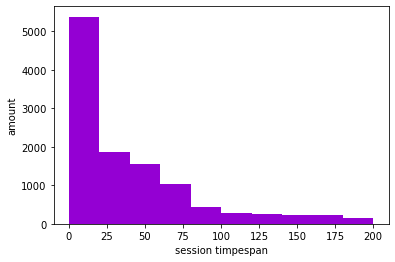

In [13]:
plt.hist(train_data_10users['session_timespan'][train_data_10users['session_timespan'] <= 200], color="darkviolet")
plt.xlabel("session timpespan")
plt.ylabel("amount")
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

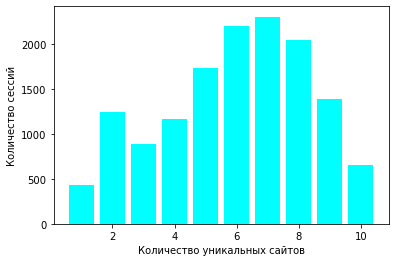

In [14]:
labels, counts = np.unique(train_data_10users['#unique_sites'].values, return_counts=True)
plt.bar(labels, counts, color="aqua")
plt.xlabel("Количество уникальных сайтов")
plt.ylabel("Количество сессий")
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

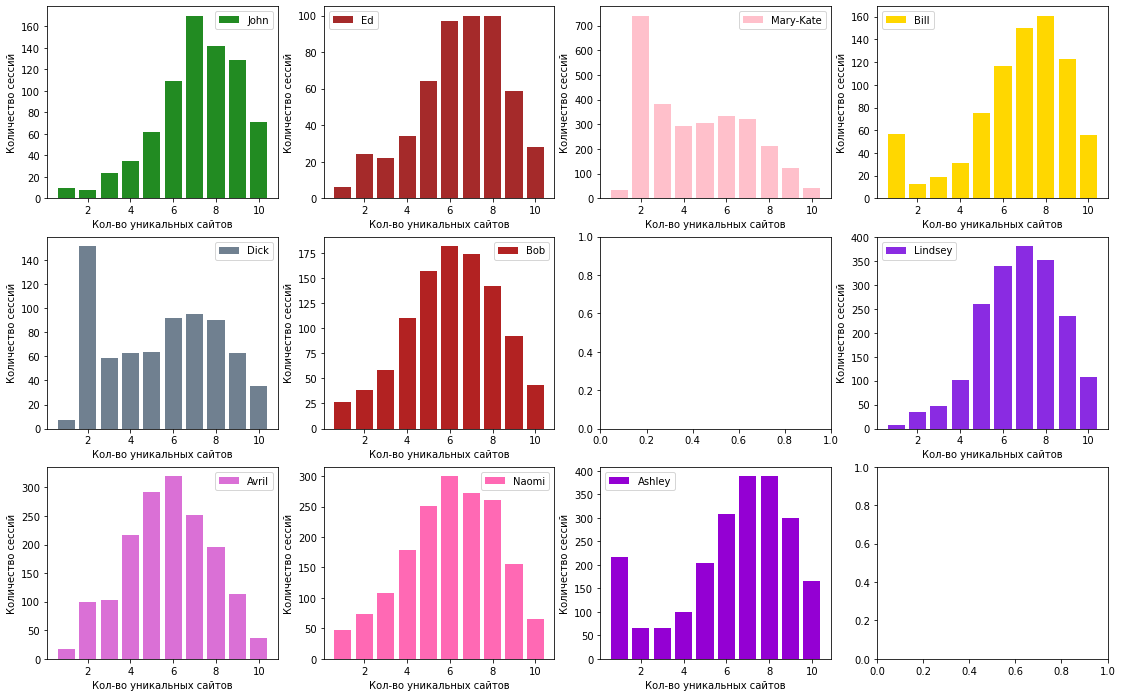

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(19, 12))

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')): 
    labels, counts = np.unique(sub_df['#unique_sites'].values, return_counts=True)
    axes[idx % 3, idx % 4].bar(labels, counts, color=color_dic[id_name_dict[user]], label=id_name_dict[user])
    axes[idx % 3, idx % 4].set(xlabel='Кол-во уникальных сайтов', ylabel='Количество сессий')
    axes[idx % 3, idx % 4].legend()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

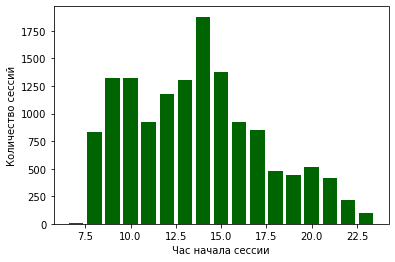

In [16]:
labels, counts = np.unique(train_data_10users['start_hour'].values, return_counts=True)
plt.bar(labels, counts, color="darkgreen")
plt.xlabel("Час начала сессии")
plt.ylabel("Количество сессий")
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

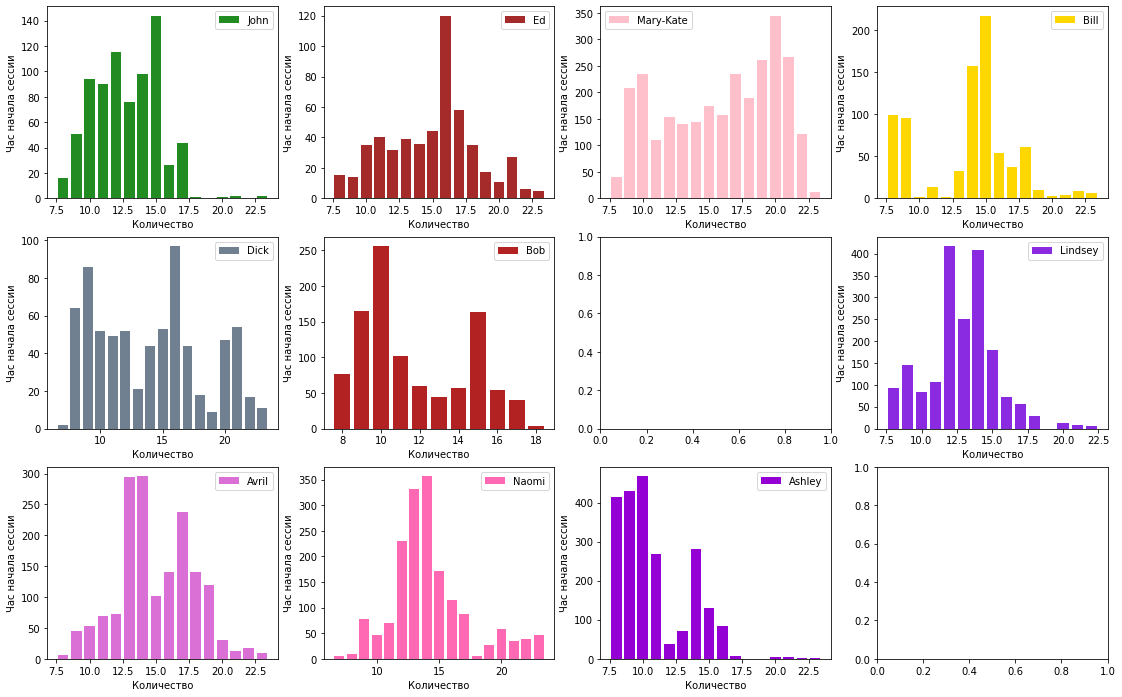

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(19, 12))

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')): 
    labels, counts = np.unique(sub_df['start_hour'].values, return_counts=True)
    axes[idx % 3, idx % 4].bar(labels, counts, color=color_dic[id_name_dict[user]], label=id_name_dict[user])
    axes[idx % 3, idx % 4].set(xlabel="Количество", ylabel='Час начала сессии')
    axes[idx % 3, idx % 4].legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

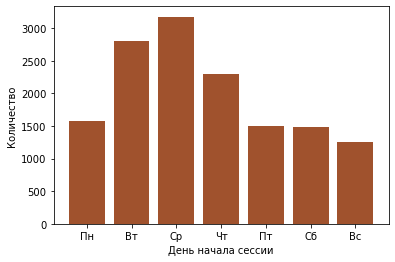

In [18]:
labels, counts = np.unique(train_data_10users['day_of_week'].values, return_counts=True)
plt.bar(labels, counts, color="sienna")
plt.xlabel("День начала сессии")
plt.ylabel("Количество")
plt.xticks(np.arange(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

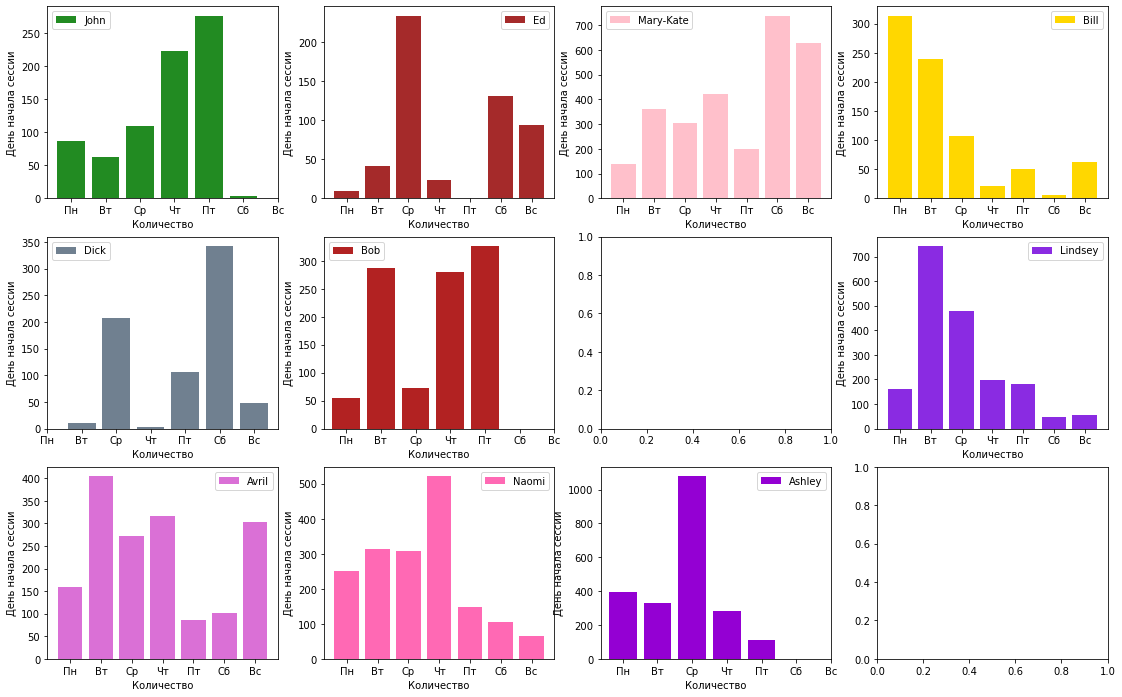

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(19, 12))

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')): 
    labels, counts = np.unique(sub_df['day_of_week'].values, return_counts=True)
    axes[idx % 3, idx % 4].bar(labels, counts, color=color_dic[id_name_dict[user]], label=id_name_dict[user])
    axes[idx % 3, idx % 4].set(xlabel="Количество", ylabel='День начала сессии')
    axes[idx % 3, idx % 4].set_xticks(np.arange(7))
    axes[idx % 3, idx % 4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    axes[idx % 3, idx % 4].legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

*Далее для каждого пользователя идут три вывода по каждому из трех постороенных графиков. Первый про число уникальных сайтов, второй про время посещения. Третий про день недели.*

**John**

- Распределение сайтов для John'a похоже на нормально с уклоном в сторону посещения большего числа уникальных сайтов. 
- Обычно John сидит в интернете в первой половине дня и с утра и практически не заходит на сайты вечером, после 17:00
- Наибольшую активность John проявляет в четверг и пятницу, и практически не заходит в интернет на выходных.

**Ed**

- Распределение сайтов для Ed'a очень похоже на распределения сайтов John'a Не думаю, что можно сделать серьезных выводов по гистограмме распределения числа уникальных сайтов - у всех 10 пользователей они похожи за некоторыми исключениями. 
- Ed проявляет активность на протяжении всего дня, но особый пик приходится на 16:00
- Ed сидит в интернете по выходным и в среду, и вообще не заходит туда в пятницу (видимо он любит пятничные вечерники, где нет места серфингу сайтов).

**Mary-Kate**

- По графику распределения сайтов для Mary-Kate можно сделать определенные выводы в отличие от остальных. Её паттерн поведения в интернете заключается в ограниченном числе уникальных сайтов - у гистограммы тяжелый левый хвост. 
- Обычно John сидит в интернете в первой половине дня и с утра и практически не заходит на сайты вечером, после 17:00
- Mary-Kate сидит в интернете много на протяжении всего дня, однако наибольшая активность приходится на вечер (примерно 20:00).

**Bill**

- Распределение сайтов для Bill'a говорит нам о том, что у него есть два поведения в интернете - либо он сидит на ограниченном количестве каких-то сайтов (смотрит youtube или сидит в facebook), либо же часто посещает различные сайты - возможно по своей работе. 
- По гистограмме о начале числа сессии можно сделать вывод, что Bill заходит в интернет с утра (посмотреть видео, пообщаться на youtube, например) и в середине дня (ищет информацию по работе).
- Bill много времени в интернете проводит в начале рабочей недели - больше всего в понедельник и вторник.

**Dick**

- По распределению числа уникальных сайтов для Dick'a можно лишь сказать, что он в большинстве случаев, предпочитает какие-то конретные сайты и лишь иногда в поисках чего-то нового. 
- Очень хаотичное распределение времени начала сессии - не думаю, что можно сделать какие-то выводы.
- Dick больше всего времени в интернете проводит в субботу и иногда заходит в интернет по будням.

**Bob**

- Распределение очень похоже на нормальное. 
- Bob больше всего времени в интернете проводит с утра.
- Bob вообще не заходит в интернет на выходных.

**Lindsey**

- Распределение практически нормальное с небольшим смещением в сторону большего количества уникальных сайтов. 
- Практически не проводит времени в интернете перед сном, большой пик приходится именно на середину дня.
- Часто заходит в интерет во вторник и очень немного по выходным.

**Avril**

- Распределение нормальное. 
- Аналогично Lindsey - мало времени в интернете проводит перед сном и много в середине дня.
- Хаотичное распределение - вряд ли можно сделать четкие выводы. Можно лишь предположить, что любит в пятницу завалиться в ночной клуб и всю субботу отсыпаться.

**Naomi**

- Распределение нормальное и очень похоже на распределение для других пользователей. Ничего уникального. 
- Большой пик на середину дня.
- Больше всего времени проводит в интернете по будням и немного на выходных.

**Ashley**

- У Ashley две стратегии поведения. Либо искать новую информацию на множестве различных сайтов. Либо же всегда сидеть на паре очень привычных для неё. 
- Ранняя пташка. Сидит в интернете утром и днем. После 18:00 практически вся активность в интернете прекращается.
- Вообще не сидит в интернете на выходных.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [20]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as site_freq_10users_pkl:
    site_freq_10users = pickle.load(site_freq_10users_pkl)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [21]:
site_freq_10users_sorted = dict(sorted(site_freq_10users.items(), key=lambda item: item[1][1], reverse=True)) 
print(list(site_freq_10users_sorted.values())[:10])

[(210, 8300), (51, 7813), (4, 5441), (183, 4158), (15, 4141), (52, 3758), (700, 3244), (214, 3094), (187, 2630), (184, 2089)]


In [22]:
top10_freqs = [id_freq[1] for id_freq in list(site_freq_10users_sorted.values())[:10]]
top10_sites = list(site_freq_10users_sorted.keys())[:10]
print(top10_freqs)
print(top10_sites)

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]
['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com']


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

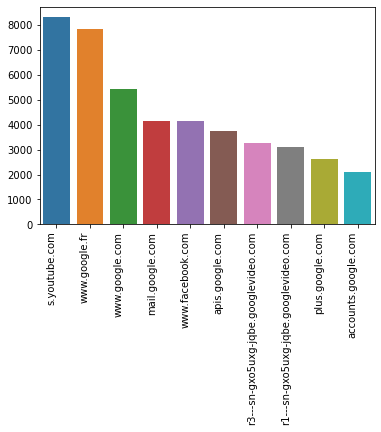

In [23]:
barplot = sns.barplot(top10_sites, top10_freqs)
barplot.set_xticklabels(barplot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [24]:
train_data_10users["session_timespan"].median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [25]:
train_data_10users["day_of_week"].median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [26]:
train_data_150users["start_hour"].median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [27]:
train_data_150users["#unique_sites"].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [28]:
def get_top_sites(site_freq_Nusers, top=20): # returns names of (top=20) most visited sites
    site_freq_Nusers_sorted = dict(sorted(site_freq_10users.items(), key=lambda item: item[1][1], reverse=True))
    return list(site_freq_Nusers_sorted.keys())[:top:]


def get_top_domens(site_freq_Nusers, threshold=0.15):   
        # returns domens which were visited 10% (or more) often as most visited domen
        
    site_names = list(site_freq_Nusers.keys())
    domen_names = list([site_names[i][site_names[i].rfind('.')+1::] for i in range(len(site_names))])
    counter_domen_names = Counter(domen_names)
    max_freq = list(counter_domen_names.values())[0]
    top_domen_names = [site for site, freq in counter_domen_names.items() if (freq / max_freq) > threshold]
    return top_domen_names

In [29]:
def feature_engineering(path_to_csv_files, site_freq_path, session_length=10, threshold=0.15):
    csv_files = glob(path_to_csv_files + "/user????.csv")
    
    with open(site_freq_path, 'rb') as f:
        site_to_id_freq = pickle.load(f)
    
    most_popular_sites = get_top_sites(site_to_id_freq)
    top_domen_names = get_top_domens(site_to_id_freq, threshold=threshold)
    
    df_columns = top_domen_names
    df_columns.extend(["#popular_sites", "month_start"])
    
    dataframe = pd.DataFrame(columns=df_columns)
    
    all_sessions_data = []
    one_session_dict = dict.fromkeys(df_columns, 0)
    
    
    for csv_file in csv_files:
        session_counter = 0
        
        data = pd.read_csv(csv_file, header=0, names=["Date_time", "Sites"])
        date_time = pd.to_datetime(data["Date_time"])
        sites = data["Sites"]
        
        for i in range(len(sites)):
            month = date_time[i].month
            one_session_dict["month_start"] = month
            
            site_domen = sites[i][sites[i].rfind('.')+1::]
            if site_domen in top_domen_names:
                one_session_dict[site_domen] += 1
            
            if sites[i] in most_popular_sites:
                one_session_dict["#popular_sites"] += 1
                
            session_counter += 1
            
            if session_counter % session_length == 0:
                all_sessions_data.append(one_session_dict.values())
                one_session_dict = dict.fromkeys(one_session_dict, 0)
                
                session_counter = 0
                
                
        if session_counter % session_length != 0:
            all_sessions_data.append(one_session_dict.values())
            one_session_dict = dict.fromkeys(one_session_dict, 0)
            
            session_counter = 0
      
        

    dataframe = pd.DataFrame(all_sessions_data, columns=df_columns)
    # print(dataframe)
    
    return dataframe   
        

In [30]:
new_features_toy = feature_engineering(
                    os.path.join(PATH_TO_DATA, '3users'), 
                    site_freq_path=os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'), 
                    session_length=10)
print(new_features_toy)

   com  ru  #popular_sites  month_start
0    9   0               4           11
1    4   0               0           11
2    3   2               0           11
3    7   1               1           11
4    2   0               0           11


In [31]:
%%time
new_features_10users = feature_engineering(
                    os.path.join(PATH_TO_DATA, '10users'), 
                    site_freq_path=os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 
                    session_length=10)

print(new_features_10users)

       com  net  fr  #popular_sites  month_start
0        3    7   0               2           11
1        7    3   0               0           11
2        6    4   0               2           11
3        2    8   0               0           11
4        3    4   0               1           11
...    ...  ...  ..             ...          ...
14056    7    0   2               7            3
14057    8    0   1               5            3
14058   10    0   0               7            3
14059   10    0   0               8            3
14060    2    0   0               1            3

[14061 rows x 5 columns]
Wall time: 3.3 s


In [32]:
%%time
new_features_150users = feature_engineering(
                    os.path.join(PATH_TO_DATA, '150users'), 
                    site_freq_path=os.path.join(PATH_TO_DATA,'site_freq_150users.pkl'), 
                    session_length=10) 

Wall time: 33.4 s


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

**Для 10 пользователей**

In [33]:
site_freq_path_10users = os.path.join(PATH_TO_DATA,'site_freq_10users.pkl')
with open(site_freq_path_10users, 'rb') as f:
    site_freq_10users = pickle.load(f)

top_domens_10users = get_top_domens(site_freq_10users)

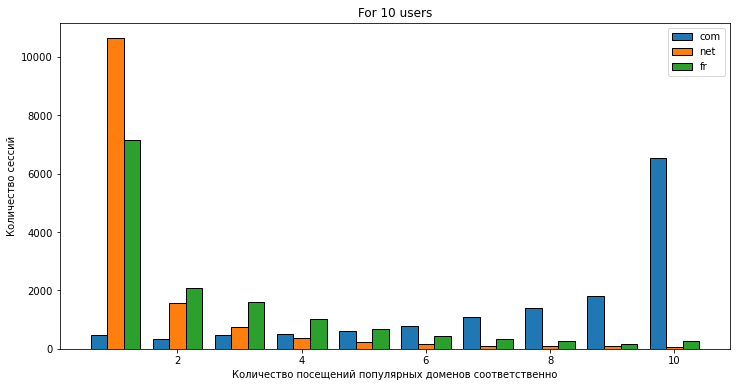

In [34]:
plt.figure(figsize=(12, 6))
plt.hist(new_features_10users[top_domens_10users], label=top_domens_10users, align="right", ec='black')
plt.xlabel("Количество посещений популярных доменов соответственно")
plt.ylabel("Количество сессий")
plt.title("For 10 users")
plt.legend()
plt.show()

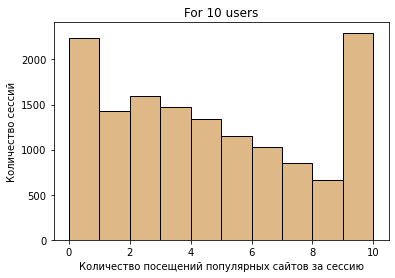

In [35]:
plt.hist(new_features_10users['#popular_sites'], color="burlywood", ec='black')
plt.xlabel("Количество посещений популярных сайтов за сессию")
plt.ylabel("Количество сессий")
plt.title("For 10 users")
plt.show()

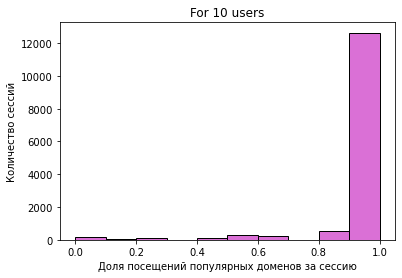

In [36]:
session_length = 10
plt.hist(new_features_10users[top_domens_10users].sum(axis=1) / session_length, color="orchid", ec="black")
plt.xlabel("Доля посещений популярных доменов за сессию")
plt.ylabel("Количество сессий")
plt.title("For 10 users")
plt.show()

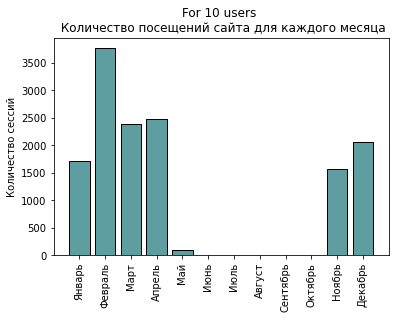

In [37]:
month_names = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль',
               'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']

labels, counts = np.unique(new_features_10users['month_start'].values, return_counts=True)
plt.bar(labels, counts, color="cadetblue", ec='black')
plt.ylabel("Количество сессий")
plt.title("For 10 users \n Количество посещений сайта для каждого месяца")
plt.xticks(np.arange(1, 13), month_names, rotation='vertical')
plt.show()

**Для 150 пользователей**

In [38]:
site_freq_path_150users = os.path.join(PATH_TO_DATA,'site_freq_150users.pkl')
with open(site_freq_path_150users, 'rb') as f:
    site_freq_150users = pickle.load(f)

top_domens_150users = get_top_domens(site_freq_150users)

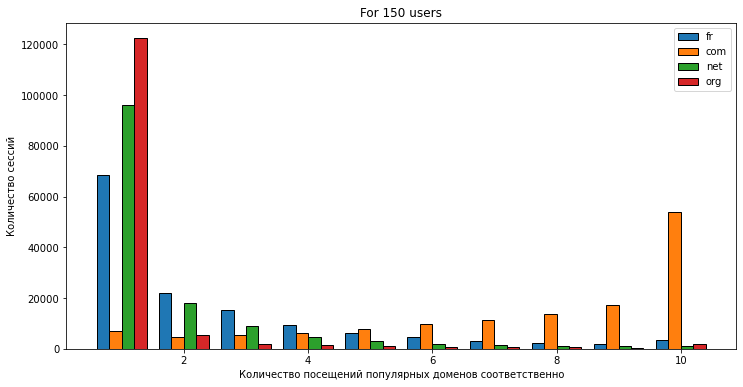

In [39]:
plt.figure(figsize=(12, 6))
plt.hist(new_features_150users[top_domens_150users], label=top_domens_150users, align="right", ec='black')
plt.xlabel("Количество посещений популярных доменов соответственно")
plt.ylabel("Количество сессий")
plt.title("For 150 users")
plt.legend()
plt.show()

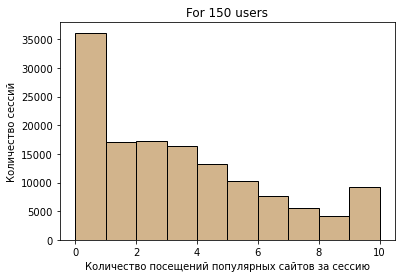

In [40]:
plt.hist(new_features_150users['#popular_sites'], color="tan", ec='black')
plt.xlabel("Количество посещений популярных сайтов за сессию")
plt.ylabel("Количество сессий")
plt.title("For 150 users")
plt.show()

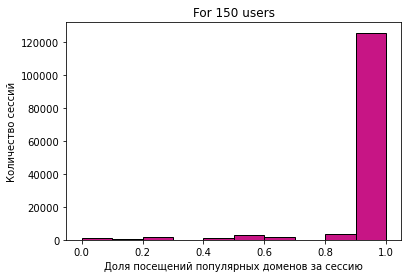

In [41]:
session_length = 10
plt.hist(new_features_150users[top_domens_150users].sum(axis=1) / session_length, color="mediumvioletred", ec="black")
plt.xlabel("Доля посещений популярных доменов за сессию")
plt.ylabel("Количество сессий")
plt.title("For 150 users")
plt.show()

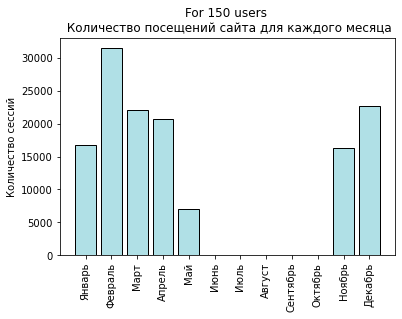

In [42]:
labels, counts = np.unique(new_features_150users['month_start'].values, return_counts=True)
plt.bar(labels, counts, color="powderblue", ec='black')
plt.ylabel("Количество сессий")
plt.title("For 150 users \n Количество посещений сайта для каждого месяца")
plt.xticks(np.arange(1, 13), month_names, rotation='vertical')
plt.show()

**Вывод**

В принципе, вывод ожидаемый: самые популярные сайты или домены посещаются очень часто (но это и так понятно из определения самых часто посещаемых сайтов). Однако для нашей задачи эти признаки могут быть полезны. Например, определенный пользователь часто заходит на популярные домены (".com", ".net") или популярные сайты ("google", "youtube", "facebook"), но это не значит, что злоумышленник также будет посещать те же популярные домены. Взломщику может не понадобиться зайти на facebook, чтобы пообщаться с кем-либо или зайти на youtube, чтобы посмотреть видео. Также есть вероятность, что прежде чем взломать чью-либо почту, злоумышленник будет посещать сомнительные сайты с необычными доменами. Если у нас будет статистика, насколько часто конкретный пользователь посещает сайты с необычными доменами, то мы можем сделать соответствующие выводы. Например, для сессий, относящихся к левой части гистограммы, никакие выводы мы сделать, вероятно, не сможем (они и так серфят интернет "где попало"), однако для правой части диаграммы, посещение необычных доменов может вызвать подозрение.

Почему-то летом и в начале осени крайне мало посещений сайтов. 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [43]:
site_freq_path_10users = os.path.join(PATH_TO_DATA,'site_freq_10users.pkl')
with open(site_freq_path_10users, 'rb') as f:
    site_freq_10users = pickle.load(f)

top_domens_10users = get_top_domens(site_freq_10users)

In [44]:
my_features_to_save10 = top_domens_10users
my_features_to_save10.extend(['month_start', '#popular_sites'])

train_data_10users.drop(columns=['target'], inplace=True)
print(my_features_to_save10)

['com', 'net', 'fr', 'month_start', '#popular_sites']


In [45]:
selected_features_10users = pd.concat([train_data_10users, new_features_10users[my_features_to_save10]], axis=1)
print(selected_features_10users.head(3))

   site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      1      2      3      4      3      3      4      3      5       3   
1      6      7      8      9      3     10     11     12     13      14   
2     14      4     14     14     15     16      6     17     18      14   

   session_timespan  #unique_sites  start_hour  day_of_week  user_id  com  \
0                33              5           8            4       31    3   
1               284             10           8            4       31    7   
2               258              7           8            4       31    6   

   net  fr  month_start  #popular_sites  
0    7   0           11               2  
1    3   0           11               0  
2    4   0           11               2  


In [46]:
site_freq_path_150users = os.path.join(PATH_TO_DATA,'site_freq_150users.pkl')
with open(site_freq_path_150users, 'rb') as f:
    site_freq_150users = pickle.load(f)

top_domens_150users = get_top_domens(site_freq_150users)

In [47]:
my_features_to_save150 = top_domens_150users
my_features_to_save150.extend(['month_start', '#popular_sites'])

train_data_150users.drop(columns=['target'], inplace=True)
print(my_features_to_save150)

['fr', 'com', 'net', 'org', 'month_start', '#popular_sites']


In [48]:
selected_features_150users = pd.concat([train_data_150users, new_features_150users[my_features_to_save150]], axis=1)
print(selected_features_150users.head(3))

   site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      1      1      2      3      1      2      1      3      4       5   
1      3      6      7      4      5      5      8      9     10      10   
2      5     11      1      1      1      1      9      5      3       1   

   session_timespan  #unique_sites  start_hour  day_of_week  user_id  fr  com  \
0                57              5           8            4        6   4    6   
1              1618              8           8            4        6   0   10   
2              2010              5           8            4        6   5    5   

   net  org  month_start  #popular_sites  
0    0    0           11               8  
1    0    0           11               1  
2    0    0           11               6  


In [49]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 